In [1]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import os

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



# Formulation of the Problem
Our goal is to estimate parameter $c$ of the acoustic wave equation, given the dataset of $u$. The formulation can be written as follows:

\begin{align}
\frac{\partial^2 u}{\partial t^2} = c^2 \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right)
    \end{align}

The true value of $c$ is $\sqrt{30/2.7} = 3.33$.

In [2]:
data = loadmat('./../Dataset/acoustic_c3.mat')
u_exact = data['u_log'].transpose(1, 0, 2)
tspan = data['t'].T

In [3]:
# Define spatial and temporal domain for the exact solution
x = np.linspace(0, 1, 101)
y = np.linspace(0, 1, 101)
t = np.linspace(0, 0.1, 101)
x_temp, y_temp, t_temp = np.meshgrid(x, y, t)

In [5]:
# Randomly select 1000 data points in the the datasat
idx = np.random.choice(x_temp.flatten()[:,None].shape[0], 1000, replace=False)
ob_x = x_temp.flatten()[:,None][idx,:]
ob_y = y_temp.flatten()[:,None][idx,:]
ob_t = t_temp.flatten()[:,None][idx,:]
ob_u = u_exact.flatten()[:,None][idx,:]

# Define Wave Equation

In [6]:
def Wave_Equation(x, y):
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    dy_yy = dde.grad.hessian(y, x, i=1, j=1)
    dy_tt = dde.grad.hessian(y, x, i=2, j=2)
    return dy_tt - C1**2 * (dy_xx + dy_yy)

def get_initial_loss(model):
    model.compile("adam", lr=0.001)
    losshistory, train_state = model.train(0)
    return losshistory.loss_train[0]

# Setup and Train Model

Compiling model...
Building Spatio-temporal Multi-scale Fourier Feature Network...


/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 6.747602 s

Training model...

Step      Train loss              Test loss               Test metric
0         [3.85e+05, 4.57e-02]    [3.85e+05, 4.57e-02]    []  

Best model at step 0:
  train loss: 3.85e+05
  test loss: 3.85e+05
  test metric: []

'train' took 5.588927 s

Compiling model...
'compile' took 2.265642 s

Training model...

Step      Train loss              Test loss               Test metric
0         [5.81e+00, 8.66e+00]    [5.81e+00, 8.66e+00]    []  
500       [2.52e-03, 8.21e-04]    [2.52e-03, 8.21e-04]    []  
1000      [8.78e-04, 2.86e-04]    [8.91e-04, 2.86e-04]    []  
1500      [4.93e-04, 1.68e-04]    [5.01e-04, 1.68e-04]    []  
2000      [3.30e-04, 1.15e-04]    [3.44e-04, 1.15e-04]    []  
2500      [2.50e-04, 8.74e-05]    [2.56e-04, 8.74e-05]    []  
3000      [2.00e-04, 8.10e-05]    [2.04e-04, 8.10e-05]    []  
3500      [1.64e-04, 6.21e-05]    [1.68e-04, 6.21e-05]    []  
4000      [1.41e-04, 2.33e-04]    [1.45e-04, 2.33e-04]    []  
4500   

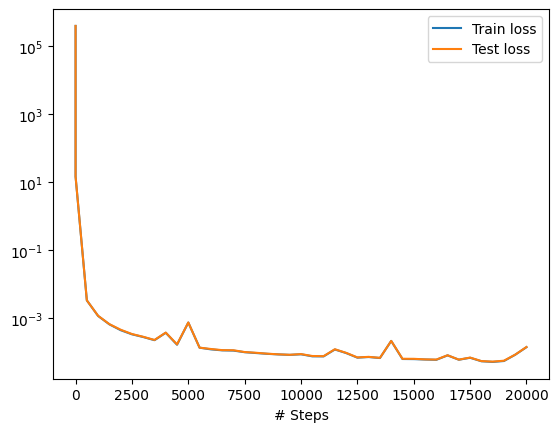

In [7]:
# true value
C1true = np.sqrt(30/2.7)

# Parameters to be identified
C1 = dde.Variable(2.0)

# Spatial domain: X × Y = [0, 1] × [0, 1]
Lx_min, Lx_max = 0.0, 1.0
Ly_min, Ly_max = 0.0, 1.0
space_domain = dde.geometry.Rectangle([Lx_min, Ly_min], [Lx_max, Ly_max])

# Time domain: T = [0, 0.1]
time_domain = dde.geometry.TimeDomain(0.0, 0.1)

# Spatio-temporal domain
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)

# Get the training data: num = 7000
ob_xyt = np.hstack((ob_x, ob_y, ob_t))
observe_u = dde.icbc.PointSetBC(ob_xyt, ob_u, component=0)

# Training datasets and Loss
data = dde.data.TimePDE(
    geomtime,
    Wave_Equation,
    [observe_u],
    num_domain=700,
    num_boundary=200,
    num_initial=100,
    anchors=ob_xyt,
)

# Neural Network setup
layer_size = [3] + [100] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.STMsFFN(layer_size, activation, initializer, sigmas_x=[1, 5], sigmas_t=[1, 5])
net.apply_feature_transform(lambda x: (x - 0.5) * 2 * np.sqrt(3))
path = "./../output/Model/model"
os.makedirs(path, exist_ok=True)
checkpoint_path = os.path.join(path, "model.ckpt")
checker = dde.callbacks.ModelCheckpoint(
      checkpoint_path, save_better_only=True, period=50
  )
model = dde.Model(data, net)

fnamevar = "./../output/variables.dat"
variable = dde.callbacks.VariableValue([C1], period=100, filename=fnamevar)

initial_losses = get_initial_loss(model)
loss_weights = 5 / initial_losses
model.compile(
    "adam",
    lr=0.001,
    external_trainable_variables=[C1],
    loss_weights=loss_weights,
    decay=("inverse time", 2000, 0.9),
)

pde_residual_resampler = dde.callbacks.PDEPointResampler(period=100) # Use pde residual sampler every 100 iterations
losshistory, train_state = model.train(
    iterations=1000000,  callbacks=[checker, pde_residual_resampler, variable], display_every=500
)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)


# Predict Solution
The prediction of variable $c$ can be founded in the file "variables.dat" which is genereated during the training.

In [8]:
x = np.linspace(0, 1, 101)
y = np.linspace(0, 1, 101)
t = np.linspace(0, 0.1, 101)
xv, yv, tv = np.meshgrid(x, y, t)

x_test = xv.flatten()[:,None]
y_test = yv.flatten()[:,None]
t_test = tv.flatten()[:,None]

ob_xyt = np.hstack((x_test, y_test, t_test))
pred = model.predict(ob_xyt)
pred2 = pred.reshape((101,101,101))